In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/Users/sbecker/Projects/RL_reward_novelty/')
import src.models.cnov.count_nov as cnov
import src.models.snov.kernel_nov as knov
from src.utils.visualization import prep_cmap, prep_cmap_discrete

from skimage.filters import gabor_kernel
import src.utils.saveload as sl

# Methods for plotting

In [2]:
def plot_kernels(ktype,k,kw_x,kc,ksig,t,splot,sseq,space,ylim=[0,0.007],plot_stim=True,base_col='grey',anim_col='k',reduce_factor=1,dashes=[(3,1,3,1),(2,2,2,2),(1,3,1,3)],cols=[]):
    
    ratio = 2.4
    lw = 3*reduce_factor
    tl = 10*reduce_factor
    fs = 4*reduce_factor

    knum = len(kw_x)

    if t>0:
        col = anim_col #'C1' # grey
    else:
        col = base_col

    f,ax = plt.subplots(1,1,figsize=(ratio*fs,fs))

    # Plot kernels
    ymin = 0
    ymax = 0
    alphs = np.array([1]*knum)
    for i in range(knum):
        ki = kw_x[i]*k(splot,kc[i],ksig[i])
        ymin = np.min([ymin,np.min(ki)])
        ymax = np.max([ymax,np.max(ki)])
        ax.plot(splot,ki,c=col,alpha=alphs[i],lw=lw)
        ax.fill_between(splot,ki,color=col,alpha=0.4)
    print(f'ylim: {ymin}, {np.round(ymax,4)}')

    # Plot stimulus locations
    alphs = np.array([1]*len(sseq))
    if len(cols)==0: 
        cols = ['C0']*len(sseq)
    for i in range(len(sseq)):
        if isinstance(sseq[i],np.ndarray):
            colm = prep_cmap_discrete('Set1') 
            cols = [colm[0],colm[3],colm[1]]
            for j in range(len(sseq[i])):
                ax.axvline(x=sseq[i][j],c=cols[j],ls=':',dashes=dashes[i],alpha=alphs[i],lw=2*lw)
        else:
            ax.axvline(x=sseq[i],c=cols[i],ls='--',alpha=alphs[i],lw=2*lw)

    # Format plot
    ax.set_xlim(space)
    ax.set_xticks([])
    ax.set_xticklabels([])
    # ax.set_xticks(sseq,lw=lw)
    # ax.set_xlabel('')
    ax.xaxis.set_tick_params(width=lw/2,length=tl)

    if len(ylim)==0:
        ylim = ax.get_ylim()
        print(ylim)
    else:
        ylim = [ymin,np.round(ymax*1.1,4)]
    ax.set_ylim(ylim)
    ax.set_yticks([])
    print(ylim[1])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
    name_save = f'kernel_{ktype}{"_neutral" if not plot_stim else ""}'

    sl.make_long_dir(path_save)
    plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True)

In [3]:
def plot_kernel_anim(ktype,k,kw,kc,ksig,t,splot,sseq,space,ylim=[0,0.007],plot_stim=True,base_col='grey',anim_col='k',reduce_factor=1):
    
    ratio = 2.4
    lw = 3*reduce_factor
    tl = 10*reduce_factor
    fs = 4*reduce_factor

    knum = len(kc)

    cols = prep_cmap('viridis',num=len(kw)+1)
    cols = cols[::-1]
    cols = cols[:-1]

    f,ax = plt.subplots(1,1,figsize=(ratio*fs,fs))

    # Plot kernels
    ymin = 0
    ymax = 0
    alphs = np.array([1]*knum)
    lh = []; ls = []
    for tt in range(len(t)):
        for i in range(knum):
            ki = kw[tt][i]*k(splot,kc[i],ksig[i])
            ymin = np.min([ymin,np.min(ki)])
            ymax = np.max([ymax,np.max(ki)])
            a = ax.plot(splot,ki,c=cols[tt],alpha=alphs[i],lw=lw)
        lh.append(a[0])
        ls.append(f't = {t[tt]}')
    print(f'ylim: {ymin}, {np.round(ymax,4)}')

    # Plot stimulus locations
    alphs = np.array([1]*len(sseq))
    cols  = ['C0']*len(sseq)
    for i in range(len(sseq)):
        ax.axvline(x=sseq[i],c=cols[i],ls='--',alpha=alphs[i],lw=2*lw)

    # Format plot
    ax.set_xlim(space)
    ax.set_xticks([])
    # ax.set_xticks(sseq,lw=lw)
    ax.set_xticklabels([])
    ax.xaxis.set_tick_params(width=lw/2,length=tl)

    if len(ylim)==0:
        ylim = ax.get_ylim()
        print(ylim)
    else:
        ylim = [ymin,np.round(ymax*1.1,4)]
    ax.set_ylim(ylim)
    ax.set_yticks([])
    print(ylim[1])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.legend(lh,ls)

    path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
    name_save = f'kernel-anim_{ktype}{"_neutral" if not plot_stim else ""}'

    sl.make_long_dir(path_save)
    plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True)



In [4]:
def sim_count_nov(states,eps,sseq,var='novelty'):
    cseq = np.array([np.where(np.min(np.abs(states-sseq[i]))==np.abs(states-sseq[i]))[0][0] for i in range(len(sseq))])
    # print(cseq)
    # print(states[cseq])

    # Initialize
    c = cnov.init_nov(states,counts0=np.array([]))

    # Update 
    nt1 = []; nt2 = []; nt3 = []; ntc = []
    for t in range(len(sseq)):
        _,nt = cnov.comp_nov(c,states,t,eps=eps)
        nt1.append(nt[cseq[0]]); nt2.append(nt[cseq[1]]), nt3.append(nt[cseq[2]]); ntc.append(nt[cseq[t]])
        c = cnov.update_nov(c,cseq[t])

    return nt1,nt2,nt3,ntc

In [5]:
def sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq,return_kw=False):
    # Initialize
    kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)

    # First update
    nt1 = []
    nt2 = []
    nt3 = []
    ntc = []
    if return_kw: 
        kwl = [kw.copy()]
    else:
        kwl = None
    for t in range(len(sseq)):
        _,_,n = knov.comp_nov(kw,kmat_seq)
        nt1.append(n[0])
        nt2.append(n[1])
        nt3.append(n[2])
        ntc.append(n[t])
        rk = knov.update_rk_approx(kw,kmat_seq,t) 
        kw = knov.update_nov_approx(kw,t,rk,knum,eps=eps)
        if return_kw: kwl.append(kw.copy())
    return nt1, nt2, nt3, ntc, kwl

In [6]:
def plot_nov_pred(nlist,cols,alphs,ls,sseq,lines=[],slabel='',reduce_factor=1,f=None,axl=[],legend=True):

    ratio = 1.2
    lw = 3*reduce_factor
    tl = 11
    fs = 4*reduce_factor
    s = 70*reduce_factor

    if len(lines)==0:
        lines = ['--']*len(alphs)

    if len(axl)==0:
        f,ax = plt.subplots(1,1,figsize=(ratio*fs,fs))
    else:
        ax = axl[0]

    lh = []
    for i in range(len(nlist)):
        ni = nlist[i]
        diff = 0 if i==0 else (ni[0]-nlist[0][0])
        ax.plot(np.arange(len(sseq)),np.array(ni)-diff,lines[i],lw=lw,c=cols[i],alpha=alphs[i])
        a = ax.scatter(np.arange(len(sseq)),np.array(ni)-diff,s=s,marker='s',c=cols[i],alpha=alphs[i])
        lh.append(a)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.set_xlabel('Time points',fontsize=tl)
    ax.set_xticks(np.arange(len(sseq)))
    ax.set_xticklabels(np.arange(len(sseq))+1,fontsize=tl)
    ax.set_ylabel('Novelty prediction',fontsize=tl)
    ax.set_yticks([])
    ax.set_ylim(ax.get_ylim()+np.array([0,0.2]))
    print(ax.get_ylim())
    if legend:
        ax.legend(lh,ls,fontsize=tl-2,loc='upper left',frameon=False)

    if len(axl)==0:
        path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
        name_save = f'pred_state-{slabel}'
        sl.make_long_dir(path_save)
        plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')

In [7]:
def plot_weights(kw,knum,t,line=False,rescale_factor=1):
    ratio = 0.6
    lw = 3*rescale_factor
    tl = 11
    fs = 4*rescale_factor

    f,axl = plt.subplots(1,len(kw),figsize=(ratio*fs*len(kw),fs),sharey=True)
    x = np.arange(knum)
    for i in range(len(kw)):
        ax = axl[i]
        ax.bar(x,kw[i].flatten(),color='k',width=0.7)
        if line: ax.axhline(y=1/knum,c='k',ls='--',lw=lw)

        # ax.set_yticks([])
        ax.set_ylim([0,0.4])
        ax.set_xticks(x)
        ax.set_xticklabels([f'$w_{j}$' for j in range(knum)],fontsize=tl)
        # ax.xaxis.set_tick_params(width=lw)
        # ax.yaxis.set_tick_params(width=lw)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        # ax.spines['left'].set_linewidth(lw)
        # ax.spines['bottom'].set_linewidth(lw)

    f.tight_layout()

    path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
    name_save = f'weight_animation'

    sl.make_long_dir(path_save)
    plt.savefig(os.path.join(path_save,f'{name_save}.svg'),bbox_inches='tight')

# Plot novelty representations

In [161]:
reduce_factor = 0.34
space = [0,180]

## Gaussian kernels

In [162]:
# Define Gauss kernel novelty
space = [0,180]
knum = 4
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([20]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_gauss,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],1000)
sseq = np.array([45,60,85,145]) 
cmap = prep_cmap_discrete('Set1')
cols = [cmap[0],cmap[3],cmap[1],cmap[0]]

# Initialize (just for plotting)
kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)

ylim: 0.0, 0.005
0.0055


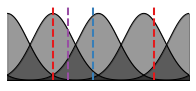

In [163]:
# Plot kernels
plot_kernels('gauss',k,kw,kc,ksig,0,splot,sseq,space,base_col='k',ylim=[0,0.006],reduce_factor=reduce_factor,cols=cols)

## Triangle kernels

In [164]:
# Define triangle kernel novelty
space = [0,180]
knum = 4
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([45]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_triangle,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],1000)
sseq = np.array([45,60,85,145]) 
cmap = prep_cmap_discrete('Set1')
cols = [cmap[0],cmap[3],cmap[1],cmap[0]]

# Initialize
kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)

ylim: 0.0, 0.0056
0.0061


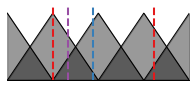

In [165]:
# Plot kernels
plot_kernels('triangle',k,kw,kc,ksig,0,splot,sseq,space,base_col='k',ylim=[0,0.006],reduce_factor=reduce_factor,cols=cols)

## Counts (large bins) / Box kernels (large)

In [13]:
# Define box kernel novelty (large bins)
space = [0,180]
knum = 4
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([45/2]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_box,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],1000)
sseq = np.array([45,60,85,145]) 
cmap = prep_cmap_discrete('Set1')
cols = [cmap[0],cmap[3],cmap[1],cmap[0]]

# Initialize
kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)

ylim: 0.0, 0.0056
0.0061


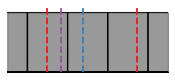

In [14]:
plot_kernels('box_large',k,kw,kc,ksig,0,splot,sseq,space,base_col='k',ylim=[0,0.003],reduce_factor=reduce_factor,cols=cols)

## Box kernels (small)

In [15]:
# Define box kernel novelty (small bins)
space = [0,180]
knum = 60
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([3/2]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_box,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],5000)
sseq = np.array([45,60,85,145]) 
cmap = prep_cmap_discrete('Set1')
cols = [cmap[0],cmap[3],cmap[1],cmap[0]]

# Initialize
kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)

ylim: 0.0, 0.0056
0.0061


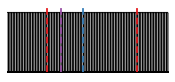

In [16]:
# Plot kernels
plot_kernels('box_small',k,kw,kc,ksig,0,splot,sseq,space,base_col='k',reduce_factor=reduce_factor,cols=cols)

# Downside 1 of cnov: |S|=num. stimuli or |S|=num. bins?

In [28]:
# Count-based novelty (|S| = number of stimuli)
sseq  = np.array([45,55,145])

# |S| = 3
eps  = 3
states = np.sort(np.unique(sseq))
n1_css, n2_css, n3_css, nt_css = sim_count_nov(states,eps,sseq)

# |S| = 2
# sseq2  = np.array([45,45,145]*2)
# eps  = 3
# states2 = np.sort(np.unique(sseq2))
# n1_css_seq2, n2_css_seq2, n3_css_seq2, nt_css_seq2 = sim_count_nov(states2,eps,sseq)

# |S| = 6
sseq2  = np.array([45,55,145]*2)
eps  = 3
states2 = sseq2
n1_css_seq2, n2_css_seq2, n3_css_seq2, nt_css_seq2 = sim_count_nov(states2,eps,sseq)

# |S| = 9
sseq3  = np.array([45,55,145]*3)
eps  = 3
states3 = sseq3
n1_css_seq3, n2_css_seq3, n3_css_seq3, nt_css_seq3 = sim_count_nov(states3,eps,sseq)

# Count-based novelty (|S| = number of bins)
# 180 bins
cnum = 180
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cs, n2_cs, n3_cs, nt_cs = sim_count_nov(states,eps,sseq)

In [29]:
# Colormap 
col_all = prep_cmap_discrete('tab20c')
cols = [col_all[0],
        col_all[1],
        col_all[2],
        col_all[4]
        ]
alphs = [1]*len(cols)
reduce_factor= 0.55
lines = []

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(1.0885787538950022, 1.5093165189033684)


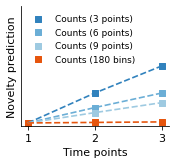

In [30]:
nlist = [nt_css,       # count-based novelty (|S|=number of stimuli)
         nt_css_seq2,  # count-based novelty (|S|=number of stimuli)
         nt_css_seq3,  # count-based novelty (|S|=number of stimuli),
         nt_cs         # count-based novelty (|S|=number of bins)
         ]
ls    = ['Counts (3 points)',
         'Counts (6 points)',
         'Counts (9 points)',
         'Counts (180 bins)'
         ]
plot_nov_pred(nlist,cols,alphs,ls,sseq,lines=lines,slabel='count-comp',reduce_factor=reduce_factor)

# Downside 2 of cnov: distinct/same vs. gradual identity?

In [31]:
sseq1  = np.array([45,45,145]) # same
sseq2  = np.array([45,60,145])
sseq3  = np.array([45,85,145])

In [32]:
# |S| = 3
eps  = 3
states = sseq1
n1_css_seq1, n2_css_seq1, n3_css_seq1, nt_css_seq1 = sim_count_nov(states,eps,sseq1)

In [33]:
# |S| = 3
eps  = 3
states = sseq2
n1_css_seq2, n2_css_seq2, n3_css_seq2, nt_css_seq2 = sim_count_nov(states,eps,sseq2)

In [34]:
# |S| = 3
eps  = 3
states = sseq3
n1_css_seq3, n2_css_seq3, n3_css_seq3, nt_css_seq3 = sim_count_nov(states,eps,sseq3)

In [35]:
# Count-based novelty (|S| = number of bins)
# 180 bins
cnum = 23
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
print(states)
n1_cs_seq1, n2_cs_seq1, n3_cs_seq1, nt_cs_seq1 = sim_count_nov(states,eps,sseq1)

# 4 bins
cnum = 4
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cl_seq1, n2_cl_seq1, n3_cl_seq1, nt_cl_seq1 = sim_count_nov(states,eps,sseq1)

# 180 bins
cnum = 23
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cs_seq2, n2_cs_seq2, n3_cs_seq2, nt_cs_seq2 = sim_count_nov(states,eps,sseq2)

# 4 bins
cnum = 4
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cl_seq2, n2_cl_seq2, n3_cl_seq2, nt_cl_seq2 = sim_count_nov(states,eps,sseq2)

# 180 bins
cnum = 23
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cs_seq3, n2_cs_seq3, n3_cs_seq3, nt_cs_seq3 = sim_count_nov(states,eps,sseq3)

# 4 bins
cnum = 4
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cl_seq3, n2_cl_seq3, n3_cl_seq3, nt_cl_seq3 = sim_count_nov(states,eps,sseq3)

[  0.           7.82608696  15.65217391  23.47826087  31.30434783
  39.13043478  46.95652174  54.7826087   62.60869565  70.43478261
  78.26086957  86.08695652  93.91304348 101.73913043 109.56521739
 117.39130435 125.2173913  133.04347826 140.86956522 148.69565217
 156.52173913 164.34782609 172.17391304]


In [36]:
# Colormap 
col_all = prep_cmap_discrete('tab20c')
cols = [col_all[0],
        col_all[1]
        ]
alphs = [1]*len(cols)
reduce_factor= 0.55
lines =[':']*len(cols) 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

(2.8408286801881215, 3.5110170964977554)
(2.9097653489206303, 3.5077343979866833)
(3.1277866819377866, 3.4973524297477714)


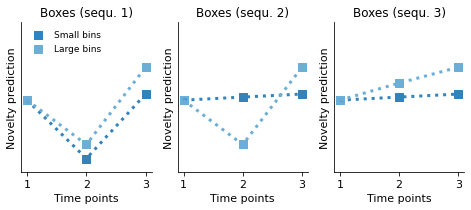

In [37]:
nlist1 = [nt_cs_seq1,         
         nt_cl_seq1
         ]
ls     = ['Small bins',
         'Large bins'
         ]
nlist2 = [nt_cs_seq2,         
         nt_cl_seq2
         ]
nlist3 = [nt_cs_seq3,         
         nt_cl_seq3
         ]

lw = 3*1.75*reduce_factor
fs = 5*reduce_factor

f,ax = plt.subplots(1,3,figsize=(fs*lw,fs))
plot_nov_pred(nlist1,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=1,axl=[ax[0]],legend=True)
plot_nov_pred(nlist2,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=1,axl=[ax[1]],legend=False)
plot_nov_pred(nlist3,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=1,axl=[ax[2]],legend=False)
for i in range(len(ax)):
    ax[i].set_title(f'Boxes (sequ. {i+1})')
    ax[i].set_ylim([2.8,3.5])
    # ax[i].set_ylim([0.8,1.5])
path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v9'
name_save = f'pred_state-box-comp'
plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')

In [38]:
# nlist = [nt_css, 
#          nt_cs_seq1,       
#          nt_cs_seq2,
#          nt_cs_seq3,  
#          nt_cl_seq1,       
#          nt_cl_seq2,
#          nt_cl_seq3
#          ]
# ls    = ['Count-based (3 points)',
#          'Small bins (sequ. 1)',
#          'Small bins (sequ. 2)',
#          'Small bins (sequ. 3)',
#          'Large bins (sequ. 1)',
#          'Large bins (sequ. 2)',
#          'Large bins (sequ. 3)'
#          ]
# plot_nov_pred(nlist,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=1)

In [39]:
# Define triangle kernel novelty
space = [0,180]
knum = 4
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([45]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_triangle,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],1000)

# Initialize
# kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)

# Simulate novelty (seq1)
n1_tk_seq1, n2_tk_seq1, n3_tk_seq1, nt_tk_seq1, kw_tk_seq1 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq1,return_kw=True)

# Simulate novelty (seq2)
n1_tk_seq2, n2_tk_seq2, n3_tk_seq2, nt_tk_seq2, kw_tk_seq2 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq2,return_kw=True)

# Simulate novelty (seq3)
n1_tk_seq3, n2_tk_seq3, n3_tk_seq3, nt_tk_seq3, kw_tk_seq3 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq3,return_kw=True)

In [40]:
# Colormap 
col_all = prep_cmap_discrete('tab20c')
cols = [col_all[4],
        col_all[5],
        col_all[6]
        ]
alphs = [1]*len(cols)
reduce_factor= 0.55
lines = [':']*len(cols) #['--','--',':','--',':'] #,'--','--']

In [41]:
# nlist1 = [nt_css, 
#          nt_tk_seq1
#          ]
# nlist2 = [nt_css, 
#          nt_tk_seq2
#          ]
# nlist3 = [nt_css, 
#          nt_tk_seq3
#          ]
# ls     = ['Count-based',
#          'Triangle kernels'
#          ]

# lw = 3*2*reduce_factor
# fs = 4*reduce_factor

# f,ax = plt.subplots(1,3,figsize=(fs*lw,fs))
# plot_nov_pred(nlist1,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=1,axl=[ax[0]],legend=False)
# plot_nov_pred(nlist2,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=1,axl=[ax[1]],legend=False)
# plot_nov_pred(nlist3,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=1,axl=[ax[2]],legend=True)
# for i in range(len(ax)):
#     ax[i].set_title(f'Sequ. {i+1}')

# path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v9'
# name_save = f'pred_state-comp-triangle'
# plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(4.950303417777132, 5.579520817352245)


TypeError: 'AxesSubplot' object is not subscriptable

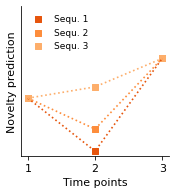

In [42]:
nlist = [ 
         nt_tk_seq1,
         nt_tk_seq2,
         nt_tk_seq3
         ]
ls    = [
         'Sequ. 1',
         'Sequ. 2',
         'Sequ. 3'
         ]
lw = 1.75*reduce_factor
fs = 5*reduce_factor
f,ax = plt.subplots(1,1,figsize=(fs*lw,fs))
plot_nov_pred(nlist,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=reduce_factor,axl=[ax])
# ax.set_ylim([0.8,1.5])
ax[i].set_ylim([2.8,3.5])
ax.set_title('Triangle kernels')
path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v9'
name_save = f'pred_state-comp-triangle'
plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')

In [419]:
# Define Gauss kernel novelty
space = [0,180]
knum = 4
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([20]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_gauss,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],1000)
# sseq  = np.array([45,55,145])
# sseq2  = np.array([45,45,145])

# Initialize (just for plotting)
# kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)
# Simulate novelty (seq1)
n1_gk_seq1, n2_gk_seq1, n3_gk_seq1, nt_gk_seq1, kw_gk_seq1 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq1,return_kw=True)

# Simulate novelty (seq2)
n1_gk_seq2, n2_gk_seq2, n3_gk_seq2, nt_gk_seq2, kw_gk_seq2 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq2,return_kw=True)

# Simulate novelty (seq3)
n1_gk_seq3, n2_gk_seq3, n3_gk_seq3, nt_gk_seq3, kw_gk_seq3 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq3,return_kw=True)

In [420]:
# Colormap 
col_all = prep_cmap_discrete('tab20c')
cols = ['k',
        # col_all[0],
        # col_all[1],
        # col_all[2],
        col_all[4],
        col_all[5],
        col_all[6],
        'k'
        # col_all[8],
        # col_all[9]
        ]
alphs = [1]*len(cols)
reduce_factor= 0.55
lines = [':']*len(cols) #['--','--',':','--',':'] #,'--','--']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.8971411192613497, 1.518432596743066)


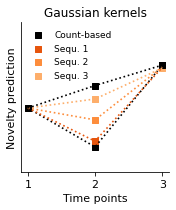

In [440]:
nlist = [nt_css_seq1,  
        #  nt_cl_seq1, 
        #  nt_cl_seq2, 
        #  nt_cl_seq3,
         nt_gk_seq1,
         nt_gk_seq2,
         nt_gk_seq3,
         nt_css_seq2
         ]
ls    = ['Count-based',
        #  'Large boxes (sequ. 1)',
        #  'Large boxes (sequ. 2)',
        #  'Large boxes (sequ. 3)',
         'Sequ. 1',
         'Sequ. 2',
         'Sequ. 3'
         ]
lw = 1.75*reduce_factor
fs = 5*reduce_factor
f,ax = plt.subplots(1,1,figsize=(fs*lw,fs))
plot_nov_pred(nlist,cols,alphs,ls,sseq,lines=lines,slabel='all',reduce_factor=reduce_factor,axl=[ax])
ax.set_title('Gaussian kernels')
ax.set_ylim([0.8,1.5])
path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v9'
name_save = f'pred_state-comp-gauss'
plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')

# Sequences

In [47]:
deg_to_rad = lambda deg: np.round((deg%360)/180,4)
obar = lambda x,angle,prec=4,x_scale=1,x_offset=0,y_scale=1,y_offset=0: np.round((np.sin(angle*np.pi)*x_scale)/(np.cos(angle*np.pi)*y_scale),prec)*(x-x_offset)+y_offset

In [48]:
def plot_seq(d,seq_id):
    d_gab  = [deg_to_rad(i) for i in d]
    d_line = [deg_to_rad(i) for i in d]

    ylim   = [[-156.91,135.035],[-323.9475,302.075]]

    f,ax = plt.subplots(1,len(d),figsize=(len(d)*3,3),subplot_kw={'box_aspect':1.0})
    for i in range(len(d_gab)):
        g = gabor_kernel(frequency=0.1, theta=d_gab[i]*np.pi, 
                        sigma_x=5.0, sigma_y=5.0, offset=0, n_stds=3)
        ax[i].imshow(np.real(g), cmap='binary',interpolation='none',origin='lower', #RdBu
                    vmin=-abs(g).max(),vmax=abs(g).max(), aspect='auto')
        ax[i].invert_yaxis()
        ax[i].axis('off')
        print([ax[i].get_xlim(), ax[i].get_ylim()])
    f.tight_layout()

    path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v10'
    name_save = f'gabor_seq{seq_id}'
    plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True)

[(-0.5, 22.5), (22.5, -0.5)]
[(-0.5, 26.5), (26.5, -0.5)]
[(-0.5, 26.5), (26.5, -0.5)]


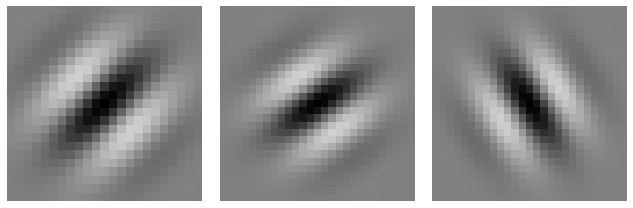

In [45]:
d      = [45,55,148]
seq_id = 1
plot_seq(d,seq_id)

[(-0.5, 22.5), (22.5, -0.5)]
[(-0.5, 26.5), (26.5, -0.5)]
[(-0.5, 26.5), (26.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]


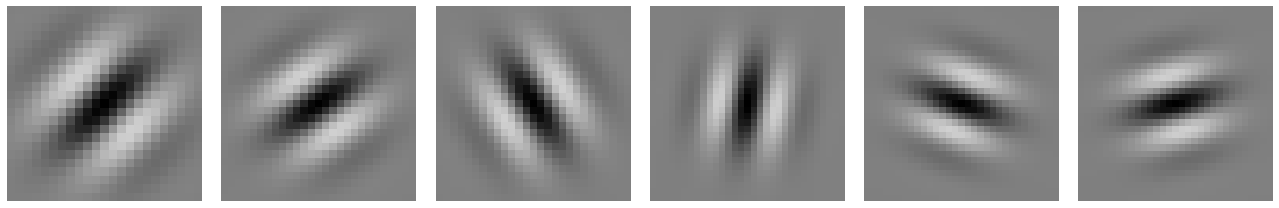

In [46]:
d      = [45,55,148, 10, 110, 75]
seq_id = 2
plot_seq(d,seq_id)

[(-0.5, 22.5), (22.5, -0.5)]
[(-0.5, 26.5), (26.5, -0.5)]
[(-0.5, 26.5), (26.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]
[(-0.5, 26.5), (26.5, -0.5)]
[(-0.5, 22.5), (22.5, -0.5)]


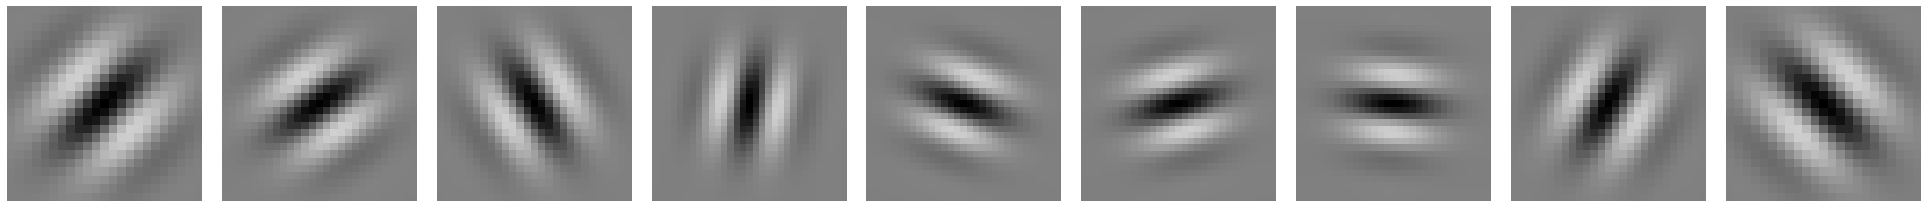

In [47]:
d      = [45,55,148, 10, 110, 75, 95, 30, 135]
seq_id = 3
plot_seq(d,seq_id)

[(-0.5, 22.5), (22.5, -0.5)]
[(-0.5, 28.5), (28.5, -0.5)]
[(-0.5, 22.5), (22.5, -0.5)]


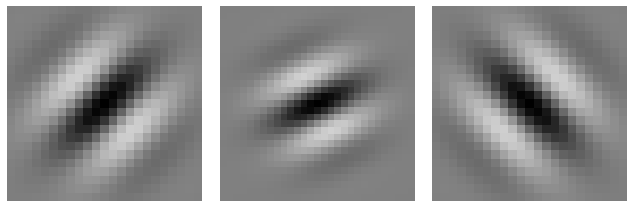

In [49]:
d      = [45,65,135]
seq_id = 4
plot_seq(d,seq_id)

[(-0.5, 22.5), (22.5, -0.5)]
[(-0.5, 30.5), (30.5, -0.5)]
[(-0.5, 22.5), (22.5, -0.5)]


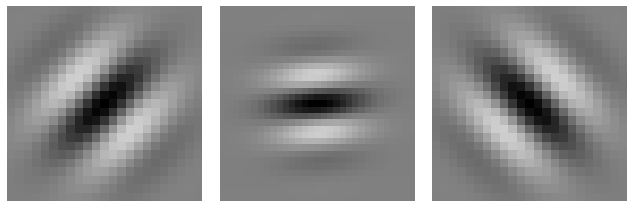

In [50]:
d      = [45,85,135]
seq_id = 5
plot_seq(d,seq_id)

# Full Figure

In [8]:
def plot_nov_pred_nonformatted(nlist,cols,alphs,ls,sseq,ax,tl,s,lw,lines=[],dashes=[],slabel='',legend=True,ref_norm=None):

    if len(lines)==0:
        lines = ['--']*len(alphs)

    if not ref_norm:
        ref_norm = nlist[0][0]

    lh = []
    for i in range(len(nlist)):
        ni = nlist[i]
        diff = ni[0]-ref_norm
        if len(dashes)>0:
            ax.plot(np.arange(len(sseq)),np.array(ni)-diff,lines[i],lw=lw,color=cols[i],alpha=alphs[i],dashes=dashes[i])
        else:
            ax.plot(np.arange(len(sseq)),np.array(ni)-diff,lines[i],lw=lw,color=cols[i],alpha=alphs[i])
        a = ax.scatter(np.arange(len(sseq)),np.array(ni)-diff,s=s,marker='s',color=cols[i],alpha=alphs[i])
        lh.append(a)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.set_xlabel('Time points',fontsize=tl)
    ax.set_xticks(np.arange(len(sseq)))
    ax.set_xticklabels(np.arange(len(sseq))+1,fontsize=tl)
    # ax.set_ylabel('Novelty prediction',fontsize=tl)
    ax.set_yticks([])
    ax.set_ylim(ax.get_ylim()+np.array([0,0.2]))
    print(ax.get_ylim())
    if legend:
        ax.legend(lh,ls,fontsize=tl-2,loc='upper left',frameon=False)
    return lh, ls

In [9]:
sseq1  = np.array([45,45,135,45]) 
sseq2  = np.array([45,60,135,45])
sseq3  = np.array([45,85,135,45])

In [10]:
# Compute count-based novelty (|S| = number of bins)
cnum_s = 9 # bin width = 20
cnum_l = 4 # bin width = 45
# 180 bins
space = [0,180]
cnum = cnum_s
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
print(states)
n1_cs_seq1, n2_cs_seq1, n3_cs_seq1, nt_cs_seq1 = sim_count_nov(states,eps,sseq1)

# 4 bins
cnum = cnum_l
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
print(states)
n1_cl_seq1, n2_cl_seq1, n3_cl_seq1, nt_cl_seq1 = sim_count_nov(states,eps,sseq1)

# 180 bins
cnum = cnum_s
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cs_seq2, n2_cs_seq2, n3_cs_seq2, nt_cs_seq2 = sim_count_nov(states,eps,sseq2)

# 4 bins
cnum = cnum_l
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cl_seq2, n2_cl_seq2, n3_cl_seq2, nt_cl_seq2 = sim_count_nov(states,eps,sseq2)

# 180 bins
cnum = cnum_s
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cs_seq3, n2_cs_seq3, n3_cs_seq3, nt_cs_seq3 = sim_count_nov(states,eps,sseq3)

# 4 bins
cnum = cnum_l
eps  = 3
states = np.linspace(space[0],space[1],cnum+1)[:-1]
n1_cl_seq3, n2_cl_seq3, n3_cl_seq3, nt_cl_seq3 = sim_count_nov(states,eps,sseq3)

[  0.  20.  40.  60.  80. 100. 120. 140. 160.]
[  0.  45.  90. 135.]


In [11]:
# Compute triangle kernel novelty
space = [0,180]
knum = 4
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([45]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_triangle,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],1000)

# Initialize
# kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)

# Simulate novelty (seq1)
n1_tk_seq1, n2_tk_seq1, n3_tk_seq1, nt_tk_seq1, kw_tk_seq1 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq1,return_kw=True)

# Simulate novelty (seq2)
n1_tk_seq2, n2_tk_seq2, n3_tk_seq2, nt_tk_seq2, kw_tk_seq2 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq2,return_kw=True)

# Simulate novelty (seq3)
n1_tk_seq3, n2_tk_seq3, n3_tk_seq3, nt_tk_seq3, kw_tk_seq3 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq3,return_kw=True)

In [12]:
# Define Gauss kernel novelty
space = [0,180]
knum = 4
eps = 3

kc =np.linspace(space[0],space[1],knum+1)[:-1]
# print(kc)
ksig = np.array([20]*knum)
k = lambda x,loc,scale: knov.fusebounds(knov.k_gauss,smin=space[0],smax=space[1],x=x,loc=loc,scale=scale)

splot = np.linspace(space[0],space[1],1000)
# sseq  = np.array([45,55,145])
# sseq2  = np.array([45,45,145])

# Initialize (just for plotting)
# kw, kmat, kmat_seq, rksum, rkmat, kmumat = knov.init_nov(k,kc,ksig,x=splot,seq=sseq)
# Simulate novelty (seq1)
n1_gk_seq1, n2_gk_seq1, n3_gk_seq1, nt_gk_seq1, kw_gk_seq1 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq1,return_kw=True)

# Simulate novelty (seq2)
n1_gk_seq2, n2_gk_seq2, n3_gk_seq2, nt_gk_seq2, kw_gk_seq2 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq2,return_kw=True)

# Simulate novelty (seq3)
n1_gk_seq3, n2_gk_seq3, n3_gk_seq3, nt_gk_seq3, kw_gk_seq3 = sim_kernel_nov(k,kc,ksig,knum,eps,splot,sseq3,return_kw=True)

In [13]:
reduce_factor= 0.7

(0.5665541024950642, 1.3821314692240296)
(0.5665541024950642, 1.5821314692240296)
(0.5665541024950642, 1.7821314692240295)
(0.5665541024950642, 1.9821314692240295)
(0.5665541024950642, 2.1821314692240295)


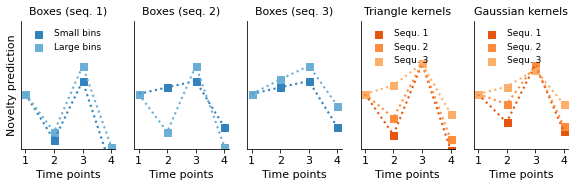

In [14]:
# Init figure
ratio = 0.24
fs = 14*reduce_factor
lw = 3*reduce_factor
tl = 11
s = 70*reduce_factor

f,ax = plt.subplots(1,5,figsize=(fs,fs*ratio),sharey=True)

# Count-based panels
col_all = prep_cmap_discrete('tab20c')
cols = [col_all[0],
        col_all[1]
        ]
alphs = [1]*len(cols)
lines =[':']*len(cols)

nlist1 = [nt_cs_seq1,         
          nt_cl_seq1
         ]
ls     = ['Small bins',
         'Large bins'
         ]
nlist2 = [nt_cs_seq2,         
         nt_cl_seq2
         ]
nlist3 = [nt_cs_seq3,         
         nt_cl_seq3
         ]

ref_norm = 1

plot_nov_pred_nonformatted(nlist1,cols,alphs,ls,sseq1,ax[0],tl,s,lw,lines=lines,legend=True,ref_norm=ref_norm)
plot_nov_pred_nonformatted(nlist2,cols,alphs,ls,sseq1,ax[1],tl,s,lw,lines=lines,legend=False,ref_norm=ref_norm)
plot_nov_pred_nonformatted(nlist3,cols,alphs,ls,sseq1,ax[2],tl,s,lw,lines=lines,legend=False,ref_norm=ref_norm)

# Kernel-based panels
cols = [col_all[4],
        col_all[5],
        col_all[6]
        ]
alphs = [1]*len(cols)
lines = [':']*len(cols) 

nlist_t = [nt_tk_seq1,
         nt_tk_seq2,
         nt_tk_seq3
         ]
nlist_g = [nt_gk_seq1,
         nt_gk_seq2,
         nt_gk_seq3
         ]
ls    = ['Sequ. 1',
         'Sequ. 2',
         'Sequ. 3'
         ]

plot_nov_pred_nonformatted(nlist_t,cols,alphs,ls,sseq1,ax[3],tl,s,lw,lines=lines,ref_norm=ref_norm)
plot_nov_pred_nonformatted(nlist_g,cols,alphs,ls,sseq1,ax[4],tl,s,lw,lines=lines,ref_norm=ref_norm,legend=True)

# Format & save
for i in range(len(ax)):
       ax[i].set_ylim([0.7,1.4])
for i in range(3):
        ax[i].set_title(f'Boxes (seq. {i+1})',fontsize=tl)
ax[3].set_title('Triangle kernels',fontsize=tl)
ax[4].set_title('Gaussian kernels',fontsize=tl)
ax[0].set_ylabel('Novelty prediction',fontsize=tl)


path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v9'
name_save = f'pred_state-all-panels'
sl.make_long_dir(path_save)
plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')

9
(0.5706886882873199, 1.29530516758666)
(0.5706886882873199, 1.49530516758666)
(0.5706886882873199, 1.69530516758666)
(0.5706886882873199, 1.89530516758666)


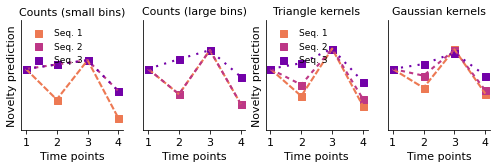

In [15]:
# Init figure
ratio = 0.24
fs = 12*reduce_factor
lw = 3*reduce_factor
tl = 11
s = 70*reduce_factor

f,ax = plt.subplots(1,4,figsize=(fs,fs*ratio),sharey=True)

# Count-based panels
# col_all = prep_cmap_discrete('Set1') #('tab20c')
# cols = [col_all[0],
#         col_all[3],
#         col_all[1]
#         ]
# col_all = prep_cmap('PRGn',8)
# print(len(col_all))
# cols = [col_all[2],
#         col_all[1],
#         col_all[0]
#         ]
# cols = [col_all[5],
#         col_all[6],
#         col_all[7]
#         ]
col_all = prep_cmap('plasma',8)
print(len(col_all))
cols = [col_all[3],
        col_all[5],
        col_all[7]
        ]
alphs = [1]*len(cols)
lines =[':']*len(cols)
dashes = [(3,1,3,1),(2,2,2,2),(1,3,1,3)]

nlist_cs = [nt_cs_seq1,         
          nt_cs_seq2,
          nt_cs_seq3
         ]
ls     = ['Seq. 1',
          'Seq. 2',
          'Seq. 3'
         ]
nlist_cl = [nt_cl_seq1,         
          nt_cl_seq2,
          nt_cl_seq3
         ]

ref_norm = 1

plot_nov_pred_nonformatted(nlist_cs,cols,alphs,ls,sseq1,ax[0],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm)
plot_nov_pred_nonformatted(nlist_cl,cols,alphs,ls,sseq1,ax[1],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=False)
# plot_nov_pred_nonformatted(nlist1,cols,alphs,ls,sseq,ax[0],tl,s,lw,lines=lines,legend=True,ref_norm=ref_norm)
# plot_nov_pred_nonformatted(nlist2,cols,alphs,ls,sseq,ax[1],tl,s,lw,lines=lines,legend=False,ref_norm=ref_norm)
# plot_nov_pred_nonformatted(nlist3,cols,alphs,ls,sseq,ax[2],tl,s,lw,lines=lines,legend=False,ref_norm=ref_norm)

# Kernel-based panels
# cols = [col_all[0],
#         col_all[3],
#         col_all[1]
#         ]
alphs = [1]*len(cols)
lines = [':']*len(cols) 
dashes = [(3,1,3,1),(2,2,2,2),(1,3,1,3)]

nlist_t = [nt_tk_seq1,
         nt_tk_seq2,
         nt_tk_seq3
         ]
nlist_g = [nt_gk_seq1,
         nt_gk_seq2,
         nt_gk_seq3
         ]
ls    = ['Seq. 1',
         'Seq. 2',
         'Seq. 3'
         ]

plot_nov_pred_nonformatted(nlist_t,cols,alphs,ls,sseq1,ax[2],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=True)
plot_nov_pred_nonformatted(nlist_g,cols,alphs,ls,sseq1,ax[3],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=False)

# Format & save
for i in range(len(ax)):
       ax[i].set_ylim([0.5,1.4])
ax[0].set_title('Counts (small bins)',fontsize=tl)
ax[1].set_title('Counts (large bins)',fontsize=tl)
ax[2].set_title('Triangle kernels',fontsize=tl)
ax[3].set_title('Gaussian kernels',fontsize=tl)
ax[0].set_ylabel('Novelty prediction',fontsize=tl)
ax[2].set_ylabel('Novelty prediction',fontsize=tl)

path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
name_save = f'pred_state-all-panels'
sl.make_long_dir(path_save)
plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')


In [17]:
ref_norm = nlist_cl[0][0]

ctA = np.array([0,1,2,2,3])
ctB = np.array([0,0,0,1,1])
t  = np.arange(len(ctA))
ntA = -np.log((eps+ctA)/(t+cnum_l*eps))
ntB = -np.log((eps+ctB)/(t+cnum_l*eps))

yt = [int(i) for i in np.arange(3)]

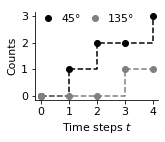

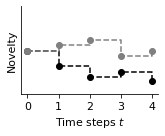

In [20]:
f,ax = plt.subplots(1,1,figsize=(2.4,2))
ax = [ax]
cc = ['k','grey']
ax[0].plot(t,ctA,'o',color=cc[0],label='$45\degree$')
ax[0].step(t,ctA,where='post',color=cc[0],ls='--')
ax[0].plot(t,ctB,'o',color=cc[1],label='$135\degree$')
ax[0].step(t,ctB,where='post',color=cc[1],ls='--')
ax[0].set_xlabel('Time steps $t$',fontsize='11')
ax[0].set_xticks(t)
ax[0].set_ylabel('Counts',fontsize='11')
yt = [int(i) for i in np.arange(ax[0].get_ylim()[1])]
ax[0].set_yticks(yt)
ax[0].tick_params(axis='both',which='major',labelsize=11)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
f.legend(loc='upper left',ncol=2,bbox_to_anchor=(0.18,1),frameon=False,fontsize=11,handletextpad=0.1,columnspacing=0.3)
f.tight_layout()
path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
plt.savefig(os.path.join(path_save,'count_based_counts.svg'))
plt.savefig(os.path.join(path_save,'count_based_counts.eps'))

f,ax = plt.subplots(1,1,figsize=(2.4,2))
ax = [None, ax]
ax[1].plot(t,ntA-ref_norm,'o',color=cc[0],label='$N_t(A)$')
ax[1].step(t,ntA-ref_norm,where='post',color=cc[0],ls='--')
ax[1].plot(t,ntB-ref_norm,'o',color=cc[1],label='$N_t(B)$')
ax[1].step(t,ntB-ref_norm,where='post',color=cc[1],ls='--')
ax[1].set_xlabel('Time steps $t$',fontsize='11')
ax[1].set_xticks(t)
ax[1].set_ylabel('Novelty',fontsize='11')
ax[1].set_yticks([])
ax[1].tick_params(axis='both',which='major',labelsize=11)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylim([-0.2,1])

f.tight_layout()
path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
plt.savefig(os.path.join(path_save,'count_based_nov.svg'))
plt.savefig(os.path.join(path_save,'count_based_nov.eps'))

9
(0.5706886882873199, 1.29530516758666)
(0.6902262899342673, 1.3762423174412104)


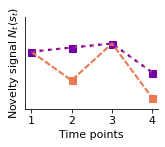

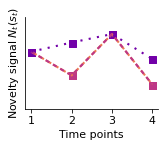

In [26]:
# Init figure

# f,ax = plt.subplots(1,2,figsize=(4.8,1.8),sharey=True)

# Count-based panels
col_all = prep_cmap('plasma',8)
print(len(col_all))
cols = [col_all[3],
        col_all[5],
        col_all[7]
        ]
alphs = [1]*len(cols)
lines =[':']*len(cols)
dashes = [(3,1,3,1),(2,2,2,2),(1,3,1,3)]

nlist_cs = [nt_cs_seq1,         
          nt_cs_seq2,
          nt_cs_seq3
         ]
ls     = ['Seq. 1',
          'Seq. 2',
          'Seq. 3'
         ]
nlist_cl = [nt_cl_seq1,         
          nt_cl_seq2,
          nt_cl_seq3
         ]

ref_norm = 1

path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
name_save = f'pred_state-cnov'
sl.make_long_dir(path_save)

f,ax = plt.subplots(1,1,figsize=(2.4,2))
ax = [ax]
lh, ls = plot_nov_pred_nonformatted(nlist_cs,cols,alphs,ls,sseq1,ax[0],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=False)
# ax[0].legend(lh,ls,fontsize=10,loc='upper left',frameon=False,bbox_to_anchor=(-0.05,1.25),ncol=2,handletextpad=0.1,columnspacing=0.3)
ax[0].set_ylim([0.5,1.3])
ax[0].set_ylabel('Novelty signal $N_t(s_t)$',fontsize=tl)
f.tight_layout()
plt.savefig(os.path.join(path_save,f'{name_save}-1.svg'),transparent=True)

f,ax = plt.subplots(1,1,figsize=(2.4,2))
ax = [ax]
lh, ls = plot_nov_pred_nonformatted(nlist_cl,cols,alphs,ls,sseq1,ax[0],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=False)
ax[0].set_ylim([0.5,1.3])
ax[0].set_ylabel('Novelty signal $N_t(s_t)$',fontsize=tl)
f.tight_layout()
plt.savefig(os.path.join(path_save,f'{name_save}-2.svg'),transparent=True)

# f.legend(lh,ls,fontsize=11,loc='upper center',frameon=False,bbox_to_anchor=(0.5, 1.1),ncol=3,handletextpad=0.1,columnspacing=0.3)

# Kernel-based panels
# alphs = [1]*len(cols)
# lines = [':']*len(cols) 
# dashes = [(3,1,3,1),(2,2,2,2),(1,3,1,3)]

# nlist_t = [nt_tk_seq1,
#          nt_tk_seq2,
#          nt_tk_seq3
#          ]
# nlist_g = [nt_gk_seq1,
#          nt_gk_seq2,
#          nt_gk_seq3
#          ]
# ls    = ['Seq. 1',
#          'Seq. 2',
#          'Seq. 3'
#          ]

# plot_nov_pred_nonformatted(nlist_t,cols,alphs,ls,sseq1,ax[2],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=True)
# plot_nov_pred_nonformatted(nlist_g,cols,alphs,ls,sseq1,ax[3],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=False)

# Format & save
# for i in range(len(ax)):
#        ax[i].set_ylim([0.5,1.3])
# ax[0].set_title('Counts (small bins)',fontsize=tl)
# ax[1].set_title('Counts (large bins)',fontsize=tl)
# ax[2].set_title('Triangle kernels',fontsize=tl)
# ax[3].set_title('Gaussian kernels',fontsize=tl)
# ax[0].set_ylabel('Novelty signal $N_t(s_t)$',fontsize=tl)
# ax[1].set_ylabel('Novelty signal $N_t(s_t)$',fontsize=tl)
# ax[0].set_yticks([1])
# ax[0].set_yticklabels(['0'])
# ax[2].set_ylabel('Novelty prediction',fontsize=tl)
# f.tight_layout()

# path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
# name_save = f'pred_state-cnov'
# sl.make_long_dir(path_save)
# plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True,bbox_inches='tight')


9
(0.6709965637381002, 1.3906758713738838)


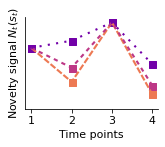

In [28]:
# Init figure

f,ax = plt.subplots(1,1,figsize=(2.4,2))
ax = [ax]

# Count-based panels
col_all = prep_cmap('plasma',8)
print(len(col_all))
cols = [col_all[3],
        col_all[5],
        col_all[7]
        ]

ref_norm = 1

# Kernel-based panels
alphs = [1]*len(cols)
lines = [':']*len(cols) 
dashes = [(3,1,3,1),(2,2,2,2),(1,3,1,3)]

nlist_t = [nt_tk_seq1,
         nt_tk_seq2,
         nt_tk_seq3
         ]
nlist_g = [nt_gk_seq1,
         nt_gk_seq2,
         nt_gk_seq3
         ]
ls    = ['Seq. 1',
         'Seq. 2',
         'Seq. 3'
         ]

# plot_nov_pred_nonformatted(nlist_t,cols,alphs,ls,sseq1,ax[0],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=False)
lh, ls = plot_nov_pred_nonformatted(nlist_t,cols,alphs,ls,sseq1,ax[0],tl,s,lw,lines=lines,dashes=dashes,ref_norm=ref_norm,legend=False)
# f.legend(lh,ls,fontsize=11,loc='upper center',frameon=False,bbox_to_anchor=(0.5, 1.1),ncol=3,handletextpad=0.1,columnspacing=0.3)

# Format & save
for i in range(len(ax)):
       ax[i].set_ylim([0.6,1.2])
# ax[0].set_title('Counts (small bins)',fontsize=tl)
# ax[1].set_title('Counts (large bins)',fontsize=tl)
# ax[2].set_title('Triangle kernels',fontsize=tl)
# ax[3].set_title('Gaussian kernels',fontsize=tl)
ax[0].set_ylabel('Novelty signal $N_t(s_t)$',fontsize=tl)
# ax[1].set_ylabel('Novelty signal $N_t(s_t)$',fontsize=tl)
# ax[0].set_yticks([1])
# ax[0].set_yticklabels(['0'])
# ax[2].set_ylabel('Novelty prediction',fontsize=tl)
# f.tight_layout()
f.tight_layout()
path_save = '/Users/sbecker/Projects/RL_reward_novelty/output/Figures_Paper/Fig_theory_kernels/v11'
name_save = f'pred_state-snov'
sl.make_long_dir(path_save)
plt.savefig(os.path.join(path_save,f'{name_save}.svg'),transparent=True) #,bbox_inches='tight')